In [47]:
import pandas as pd
from modeling import LightningBinConv
from data import TSDataset, TSDatasetTest
from torch.utils.data import DataLoader
from preprocessing import get_preprocessing_pipeline
import lightning.pytorch as pl
import matplotlib.pyplot as plt

In [48]:
# download toy dataset to validate the methods
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/"
    "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
    index_col=0,
    parse_dates=True,
)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [49]:
#hyperparameters
prediction_length = 12
context_length = 12
num_bins = 1000
min_value = -3
max_value = 3
offset = -36 # for train/test split

In [50]:
train_data = df.values[:offset]
test_data = df.values[offset-context_length:]

In [51]:
pipeline = get_preprocessing_pipeline()

In [52]:
net = LightningBinConv(
    context_length=context_length,
    num_bins=num_bins
)

In [53]:
dataset = TSDataset(data=train_data, context_length=context_length, scaler=pipeline)
train_loader = DataLoader(dataset, batch_size=int(1e6), shuffle=True)

In [54]:
trainer = pl.Trainer(max_epochs=600)
trainer.fit(net, train_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | Conv2d     | 296    | train
1 | mlp  | Sequential | 2.0 M  | train
--------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.009     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/andreicher

Training: |          | 0/? [00:00<?, ?it/s]

tensor(0.6933, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1066, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0716, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0808, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0606, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0613, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0610, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0590, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0566, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0554, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0555, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0557, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0549, device='mps:0', grad_fn=<

`Trainer.fit` stopped: `max_epochs=600` reached.


tensor(2.3541e-05, device='mps:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(2.3376e-05, device='mps:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [55]:
test_dataset = TSDatasetTest(data=test_data, context_length=context_length, scaler=train_loader.dataset.scaler)
test_loader = DataLoader(test_dataset, batch_size=int(1e6),shuffle=False)

In [56]:
test_sample = next(iter(test_loader))

In [57]:
test_sample.shape

torch.Size([36, 12, 1000])

In [58]:
import numpy as np

#TODO: this is ugly, rewrite in future
def extract_forecasts(pred_samples, window, context_length):
    """
    Extracts and concatenates forecast windows from pred_samples.

    Args:
        pred_samples (np.ndarray): Array of prediction samples (e.g. [num_samples, forecast_len]).
        window (int): Number of forecast windows to extract.
        context_length (int): Number of context steps between each forecast start.

    Returns:
        np.ndarray: Concatenated forecast windows.
    """
    indices = [(i * (context_length + 1)) for i in range(window)]
    windows = [pred_samples[i][:context_length] for i in indices]
    return np.concatenate(windows)

In [59]:
pred_samples = net.predict(test_sample, context_length)
pred_samples = pipeline.inverse_transform(pred_samples.numpy())

In [60]:
pred  = extract_forecasts(pred_samples, 3, context_length)

In [61]:
pred

array([316.58545184, 303.79630204, 344.72158141, 344.72158141,
       344.72158141, 403.55167051, 421.45648024, 403.55167051,
       375.41554094, 344.72158141, 303.79630204, 334.49026157,
       334.49026157, 344.72158141, 344.72158141, 344.72158141,
       403.55167051, 421.45648024, 403.55167051, 372.85771098,
       344.72158141, 303.79630204, 344.72158141, 334.49026157,
       372.85771098, 372.85771098, 372.85771098, 411.2251604 ,
       421.45648024, 421.45648024, 421.45648024, 403.55167051,
       354.95290126, 372.85771098, 354.95290126, 354.95290126])

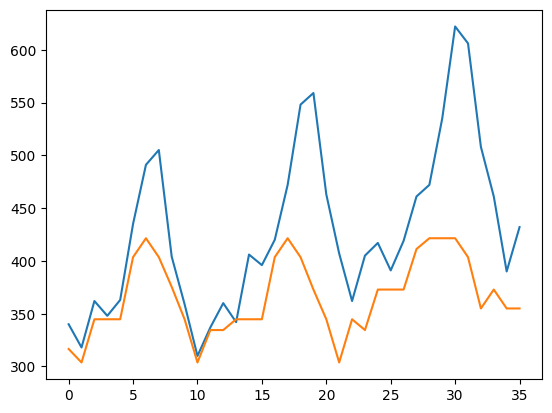

In [62]:
plt.plot(test_data[context_length:])
plt.plot(pred)